In [32]:
# %matplotlib notebook
from skimage import io, measure, feature, util, color, morphology
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import pandas as pd
from scipy.spatial import distance
import numpy as np
import scipy.interpolate as itp
from matplotlib.patches import Ellipse
import trackpy as tp
plt.style.use('/projects/DEIKE/jiarongw/jiarongw-postprocessing/media/matplotlib/stylelib/pof.mplstyle')

In [14]:
images = [color.rgb2gray(color.rgba2rgb(io.imread('frame{}.png'.format(i)))) for i in [1, 2]]

ppties = ['label', 'area', 'centroid', 'eccentricity', 'orientation', 'equivalent_diameter', 'major_axis_length', 'minor_axis_length']

def detect_crests(im):
    im_lab = measure.label(im) #im: binary image
    props = measure.regionprops_table(im_lab, properties=ppties)
    #link: https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops
    return pd.DataFrame(props).set_index('label')

crests = [detect_crests(im) for im in images]

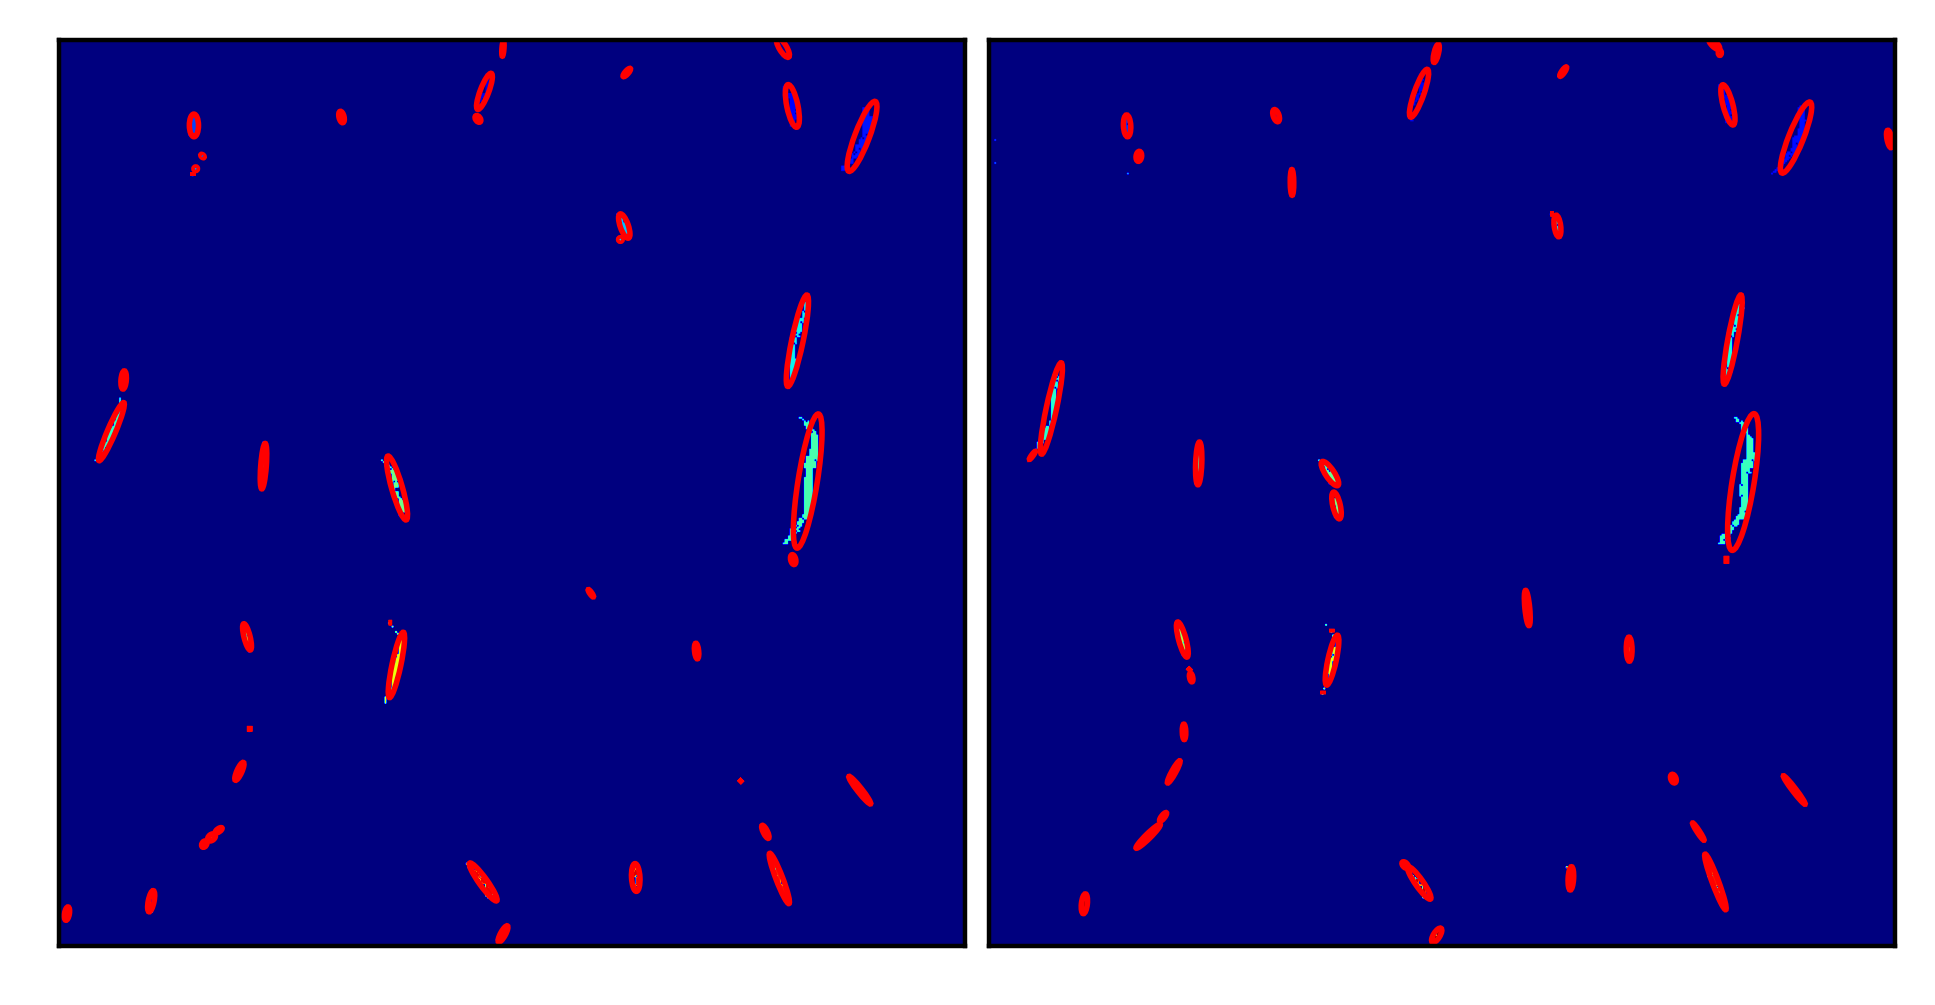

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0)

angle = lambda theta: np.degrees((2*(theta>=0)-1)*np.pi/2 - theta)

cm = plt.get_cmap('jet')
for im, ax, props in zip(images, axs, crests):
    ax.imshow(measure.label(im), cmap=cm)
    ax.set_xticks(())
    ax.set_yticks(())
    for i, p in props.iterrows():
        e = Ellipse(p[['centroid-1', 'centroid-0']], p['major_axis_length'], p['minor_axis_length'],
                   angle(p['orientation']), ec='r', fc='none')
        ax.add_patch(e)
        

## Track crests

Histogram of distances between detected crests: ideally the minimal distance between 2 crests (in a single frame) should be larger than the maximal displacement between 2 frames.

In [ ]:
dist = np.concatenate([distance.pdist(c[['centroid-0', 'centroid-1']]) for c in crests])
fig, ax = plt.subplots()
out = ax.hist(dist, bins=np.logspace(0, 3, 20), density=True)
ax.set_yscale('log')
ax.set_xscale('log')

Aaaaaand... the min. distance is 2.5 here, so let's try `search_range=2`. Which does not seem to work. I would stick with something between 5 and 10, since most of the distances are higher than that.

In [16]:
crests_df = pd.concat(dict(enumerate(crests)), names=['frame']).reset_index()
crests_df.rename(columns={'centroid-0': 'y', 'centroid-1': 'x'}, inplace=True)
crests_df = tp.link_df(crests_df, search_range=5)

crests_gr = crests_df.groupby('particle')
crests_df['dx'] = crests_gr['x'].diff()
crests_df['dy'] = crests_gr['y'].diff()

Frame 1: 50 trajectories present.


In [27]:
crests_df[np.isnan(crests_df.dx)==False]

,frame,label,area,y,x,eccentricity,orientation,equivalent_diameter,major_axis_length,minor_axis_length,particle,dx,dy
72,1,32,35,344.000000,361.028571,0.971137,0.015825,6.675581,13.557833,3.233855,4,1.457143,-1.071429
68,1,28,49,338.571429,108.510204,0.979049,0.262543,7.898654,20.483668,4.171003,1,2.995918,1.514286
69,1,29,1,330.000000,190.000000,0.000000,0.785398,1.128379,0.000000,0.000000,2,2.000000,-1.000000
71,1,31,72,350.208333,193.111111,0.986497,-0.214483,9.574615,28.823998,4.720718,3,3.181111,-2.711667
77,1,37,15,390.733333,109.466667,0.973723,0.027749,4.370194,8.701580,1.981655,5,2.466667,1.733333
87,1,47,32,476.125000,242.406250,0.980152,0.609988,6.383076,22.143582,4.389890,13,3.440148,0.565678
79,1,39,12,417.166667,386.000000,0.810370,0.345668,3.908820,5.047399,2.957361,8,1.500000,-1.333333
80,1,40,22,423.590909,454.318182,0.995016,0.652685,5.292567,20.118872,2.006087,7,2.536932,-0.096591
82,1,42,32,449.750000,89.187500,0.989716,-0.793024,6.383076,19.078508,2.729106,9,-0.312500,3.416667
83,1,43,11,447.090909,400.090909,0.992961,0.582560,3.742410,11.600639,1.374043,20,1.674242,-0.159091


(512.0, 0.0)

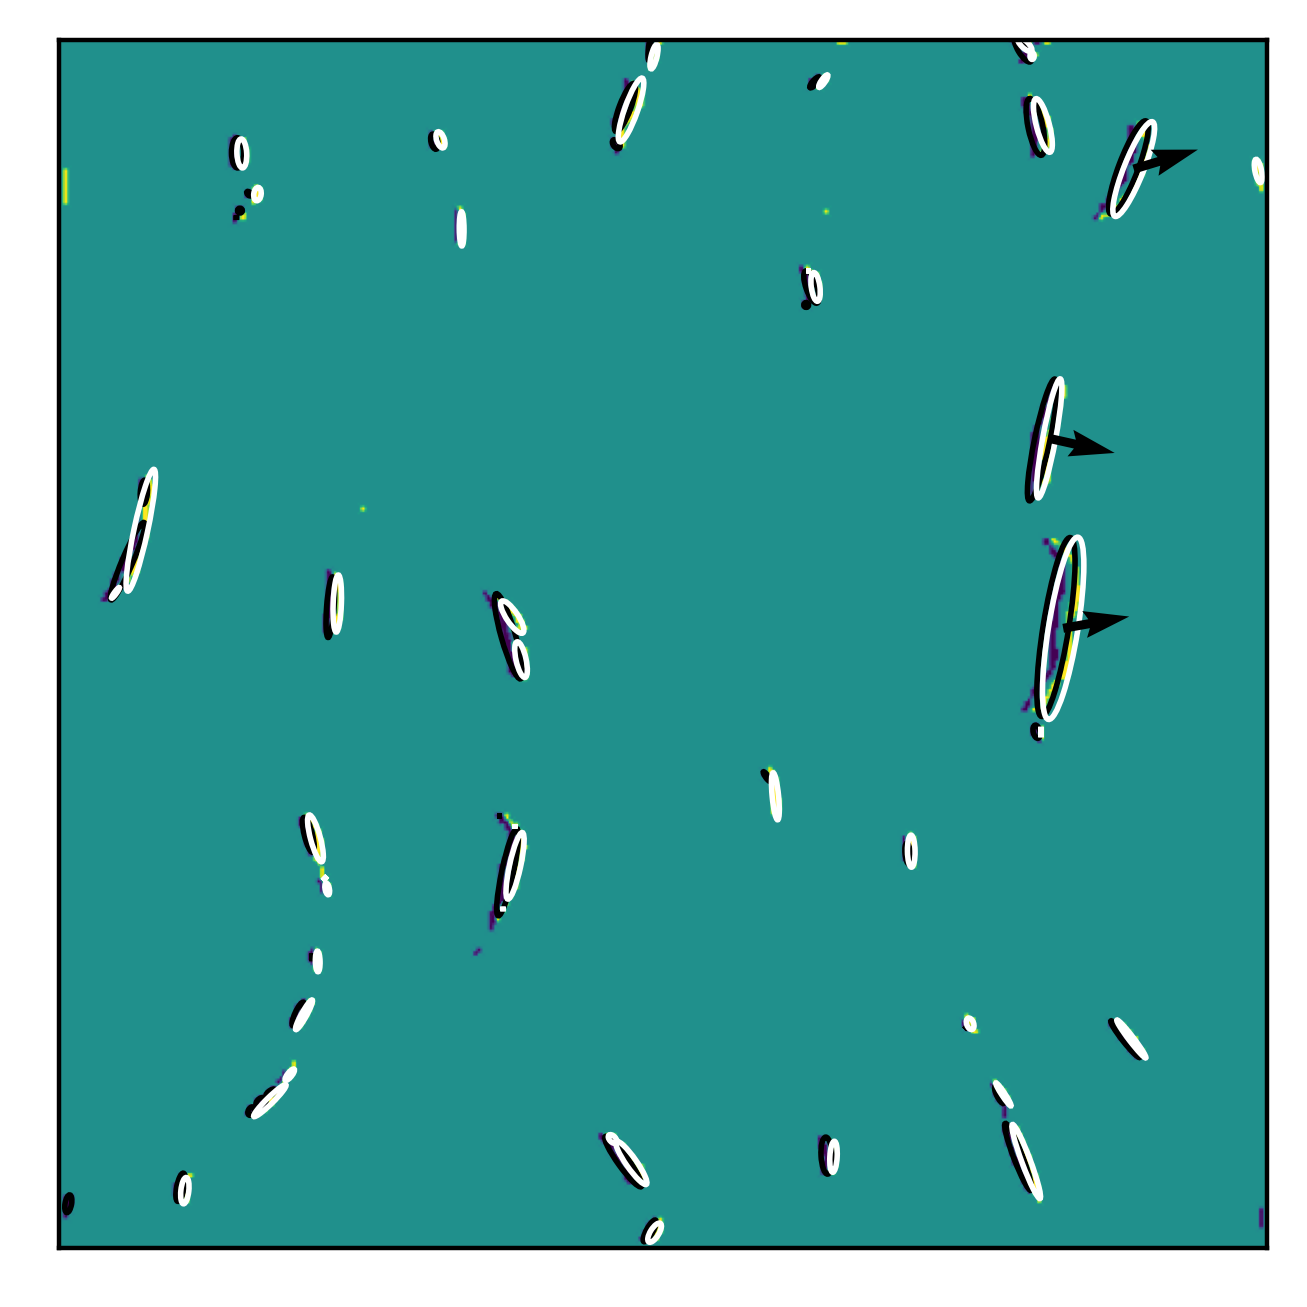

In [53]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(np.diff(images, axis=0)[0])
for c, props in zip('kw', crests):
    for i, p in props.iterrows():
        e = Ellipse(p[['centroid-1', 'centroid-0']], p['major_axis_length'], p['minor_axis_length'],
                   angle(p['orientation']), ec=c, fc='none')
        ax.add_patch(e)
# ax.quiver(*crests_df[['x', 'y', 'dx', 'dy']].values.T, )
ax.quiver(*crests_df[crests_df.label==21][['x', 'y', 'dx', 'dy']].values.T, )
ax.quiver(*crests_df[crests_df.label==7][['x', 'y', 'dx', 'dy']].values.T, )
ax.quiver(*crests_df[crests_df.label==19][['x', 'y', 'dx', 'dy']].values.T, )
ax.set_xticks(())
ax.set_yticks(())
ax.set_xlim(0, 512)
ax.set_ylim(512, 0)

In [56]:
print (crests_df[crests_df.label==21].dx*50/512/0.1)
print (crests_df[crests_df.label==7].dx*50/512/0.1)
print (crests_df[crests_df.label==19].dx*50/512/0.1)

20         NaN
61    2.996422
Name: dx, dtype: float64
6          NaN
47    2.189418
Name: dx, dtype: float64
18         NaN
59    2.890863
Name: dx, dtype: float64


## Refine analysis
Then you can refine the analysis based on the shape of the crests (ideas):
- take orientation and/or eccentricity into account,
- once you match the crests from one frame to the next, you could interpolate each crest on a line $\{x(s), y(s)\}$, with the arclength $s$ from 0 to 1, then at fixed $s$ calculate the displacement between 2 frames (treat it as a material point).

### Work on a single wave crest
Get largest wave crest on both frames, then skeletonize, retrieve coordinates and fit a smooth spline on it.

In [30]:
def detect_crests(im):
    im_lab = measure.label(im) #im: binary image
    props = measure.regionprops(im_lab) #output region properties in their native format
    #link: https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops
    return props

# get largest crest
props = [detect_crests(im) for im in images]
crest = [x[np.argmax([p.area for p in x])] for x in props]

In [40]:
dir(crest[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_cache_active',
 '_extra_properties',
 '_image_intensity_double',
 '_intensity_image',
 '_label_image',
 '_multichannel',
 '_ndim',
 '_slice',
 '_spatial_axes',
 'area',
 'area_bbox',
 'area_convex',
 'area_filled',
 'axis_major_length',
 'axis_minor_length',
 'bbox',
 'centroid',
 'centroid_local',
 'centroid_weighted',
 'centroid_weighted_local',
 'coords',
 'eccentricity',
 'equivalent_diameter_area',
 'euler_number',
 'extent',
 'feret_diameter_max',
 'image',
 'image_convex',
 'image_filled',
 'image_intensity',
 'inertia_tensor',
 'inertia_tensor_eigvals',
 'i

213 409 285 429
213 412 285 433


(290.0, 210.0)

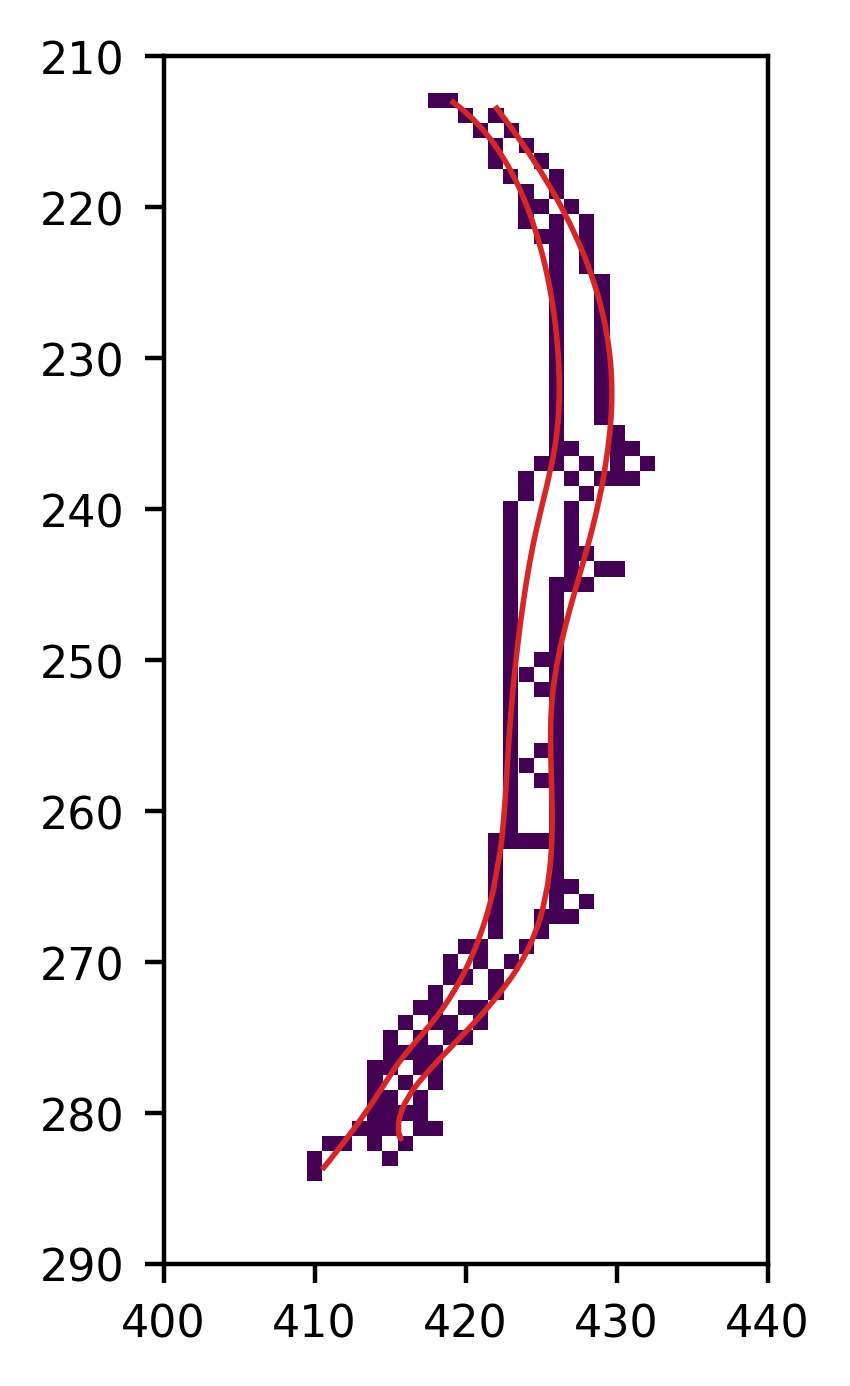

In [41]:
fig, ax = plt.subplots()
splines = []
for c in crest:
    r0, c0, r1, c1 = c.bbox
    print(r0,c0,r1,c1)
    skel = morphology.skeletonize(c.image)
    ax.imshow(~np.ma.masked_equal(skel, 0), extent=np.r_[c0, c1, r1, r0]-.5)
    r, c = np.where(skel > 0)
    s = np.cumsum(np.sqrt(np.diff(r)**2+np.diff(c)**2))
    s = np.concatenate([[0], s])/s[-1]
    x = itp.splrep(s, c+c0, k=3, s=100)
    y = itp.splrep(s, r+r0, k=3, s=100)
    splines.append([x, y])
    ax.plot(itp.splev(s, x), itp.splev(s, y), 'C3', lw=1)

ax.set_xlim(400, 440)
ax.set_ylim(290, 210)